# Demonstrate bias in hierarchical modeling of power law

### We construct time-domain data obeying a power law. The data is modeled using a collection of Fourier coefficients, and hierarchically modeled with an amplitude and spectral index which describe the power law. We observe bias in the hyper-parameters depending on the number of frequency bins included in the model.

# Simulate data

In [1]:
from jax import vmap
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from corner import corner

from BayesFT import functions as f
from BayesFT import hierarchical_models as hm
from BayesFT.PTMCMC import PTMCMC
from BayesFT import jumps

In [2]:
# time series over which data is collected
t0 = 0.
t1 = 1.
Tspan = t1 - t0
Nt = 100
t = jnp.linspace(t0, t1, Nt)

# frequency bins injected into data (neglecting zero frequency)
Nf_inj = t.shape[0] // 2
Na_inj = 2 * Nf_inj
f_inj = jnp.arange(1, Nf_inj + 1) / Tspan
logf_inj = jnp.log(f_inj)
df_inj = f_inj[1] - f_inj[0]

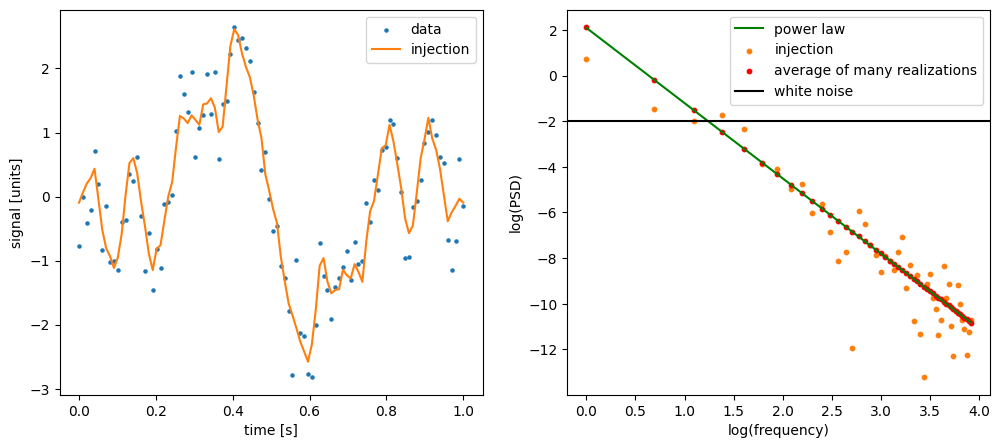

In [3]:
# injected hyper-parameters
log_amp_inj = 1.4
gamma_inj = 3.3
hypers_inj = jnp.array([log_amp_inj, gamma_inj])
diag_cov_inj = f.fast_diag_power_law_cov(log_amp_inj, gamma_inj, f_inj)

# use Cholesky decomposition to make correlated Fourier coefficients
a_seed = jr.PRNGKey(4)  # seed for injected Fourier coefficients
a_inj = np.sqrt(diag_cov_inj) * jr.normal(a_seed, shape=(Na_inj,))

# check accuracy of injection by averaging over many realizations
many_a = np.sqrt(diag_cov_inj) * jr.normal(a_seed, shape=(10_000, Na_inj))

# simulate power law signal in time-domain
F_inj = f.fast_Fourier_design(t, f_inj)
signal_inj = F_inj @ a_inj

# add zero-mean Gaussian noise
log_sigma_inj = -1.0
sigma_inj = np.exp(log_sigma_inj)
noise_seed = jr.PRNGKey(1)
noise = jr.normal(noise_seed, shape=(Nt,)) * sigma_inj

# make and plot data
data = signal_inj + noise

# time-domain
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(t, data, color='C0', s=5, label='data')
plt.plot(t, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()

# frequency-domain
plt.subplot(1, 2, 2)
plt.plot(logf_inj, np.log(diag_cov_inj[::2] + diag_cov_inj[1::2]), color='green', label='power law')
plt.scatter(logf_inj, np.log(a_inj[::2]**2. + a_inj[1::2]**2.), color='C1', s=10, label='injection')
plt.scatter(logf_inj, np.log(np.mean(many_a[:,::2]**2. + many_a[:,1::2]**2., axis=0)), color='red', s=10, 
            label='average of many realizations')
plt.axhline(np.log(sigma_inj**2. * df_inj), color='k', label='white noise')
plt.xlabel('log(frequency)')
plt.ylabel('log(PSD)')
plt.legend()
plt.show()

# Model specification

In [15]:
# compare bias in two models
model_1_Nf = 4  # number of frequency bins in model 1
model_2_Nf = 8  # number of frequency bins in model 2
model_1 = hm.Hierarchical_Model(t, data, model_1_Nf)
model_2 = hm.Hierarchical_Model(t, data, model_2_Nf)

# point near maximum likelihood (ML) solution
a_ML_1 = jnp.linalg.pinv(model_1.F) @ data
log_sigma_ML_1 = jnp.log(jnp.sqrt(jnp.sum((data - model_1.F @ a_ML_1)**2.) / Nt))
x_ML_1 = jnp.concatenate((hypers_inj, a_ML_1, jnp.array([log_sigma_inj])))

a_ML_2 = jnp.linalg.pinv(model_2.F) @ data
log_sigma_ML_2 = jnp.log(jnp.sqrt(jnp.sum((data - model_2.F @ a_ML_2)**2.) / Nt))
x_ML_2 = jnp.concatenate((hypers_inj, a_ML_2, jnp.array([log_sigma_ML_2])))

# MCMC

In [5]:
# jump proposals: Fisher and differential evolution
Fisher_1 = jumps.FisherJumps(x_ML_1, model_1.fast_lnpost)
DEjumps_1 = jumps.DifferentialEvolution(100, model_1.x_min, model_1.x_max)
jump_proposals_1 = [[Fisher_1.vectorized_Fisher_jump, 20],
                      [DEjumps_1.vectorized_DE_jump, 10]]

# do parallel tempering MCMC
num_samples = int(3e5)
num_chains = 10
samples_1, lnposts_1, temp_ladder_1 = PTMCMC(num_samples=num_samples,
                                             num_chains=num_chains,
                                             x0=x_ML_1,
                                             lnpost_func=model_1.fast_lnpost,
                                             # lnpost_func=model_Nf4.fast_lnprior_recovery,
                                             jump_proposals=jump_proposals_1,
                                             PT_weight=10)

Jump acceptance rates
Fisher_jump: [0.5771655  0.55026646 0.51607073 0.47313764 0.43349941 0.3989235
 0.37398537 0.34279769 0.30381309 0.26530204]
DE_jump: [0.07151505 0.07494778 0.07674397 0.07647787 0.07083649 0.06873428
 0.0721404  0.07019785 0.06848149 0.06828191]
PT swap: [0.64786608 0.63268766 0.61820342 0.63834786 0.66893164 0.67154815
 0.63424956 0.64713185 0.72601423        nan]


/Users/aidengundersen/Desktop/BayesFT/BayesFT/PTMCMC.py:167: RuntimeWarning: invalid value encountered in divide
  acceptance_rates = accept_counts / (accept_counts + reject_counts)


In [6]:
# jump proposals: Fisher and differential evolution
Fisher_2 = jumps.FisherJumps(x_ML_2, model_2.fast_lnpost)
DEjumps_2 = jumps.DifferentialEvolution(100, model_2.x_min, model_2.x_max)
jump_proposals_2 = [[Fisher_2.vectorized_Fisher_jump, 20],
                      [DEjumps_2.vectorized_DE_jump, 10]]

# do parallel tempering MCMC
samples_2, lnposts_2, temp_ladder_2 = PTMCMC(num_samples=num_samples,
                                             num_chains=num_chains,
                                             x0=x_ML_2,
                                             lnpost_func=model_2.fast_lnpost,
                                             # lnpost_func=model_Nf4.fast_lnprior_recovery,
                                             jump_proposals=jump_proposals_2,
                                             PT_weight=10)

Jump acceptance rates
Fisher_jump: [0.68490572 0.66196003 0.62123641 0.5569286  0.49116424 0.45320741
 0.42132287 0.3906754  0.35117555 0.32064115]
DE_jump: [0.06818151 0.07144673 0.07105865 0.0662545  0.05736882 0.0541839
 0.05728853 0.06209268 0.06862312 0.07274479]
PT swap: [0.4832815  0.45657194 0.46251185 0.51737256 0.58640896 0.60664469
 0.58859805 0.62664015 0.7280991         nan]


/Users/aidengundersen/Desktop/BayesFT/BayesFT/PTMCMC.py:167: RuntimeWarning: invalid value encountered in divide
  acceptance_rates = accept_counts / (accept_counts + reject_counts)


# Post-processing

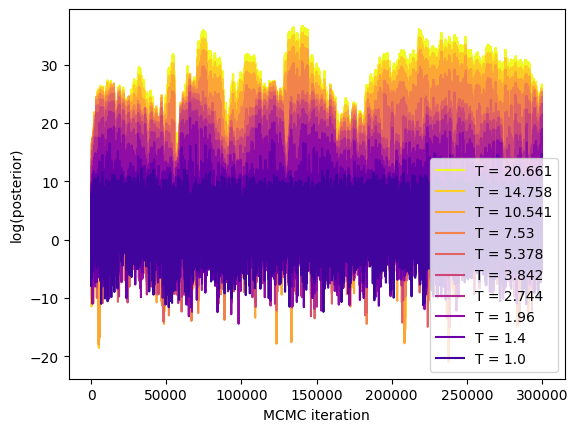

In [7]:
# plot posterior values of chains (with temperature scaling)
chain_colors = list(reversed([plt.cm.plasma(i / num_chains) for i in range(1, num_chains + 1)]))
for j, (temp, color) in enumerate(zip(temp_ladder_1[::-1], chain_colors)):
    plt.plot(lnposts_1[::-1][j], color=color, label=f'T = {round(temp, 3)}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.legend(loc='lower right')
plt.show()

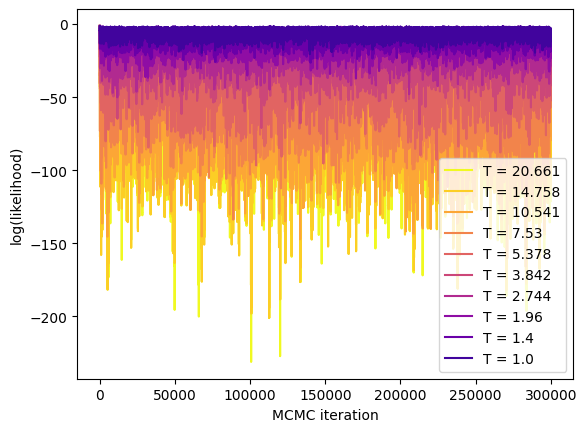

In [8]:
# plot likelihood values (without temperature scaling)
vectorized_lnlike = vmap(model_1.fast_lnlike)
for j, (temp, color) in enumerate(zip(temp_ladder_1[::-1], chain_colors)):
    plt.plot(vectorized_lnlike(samples_1[::-1][j]), color=color, label=f'T = {round(temp, 3)}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(likelihood)')
plt.legend(loc='lower right')
plt.show()

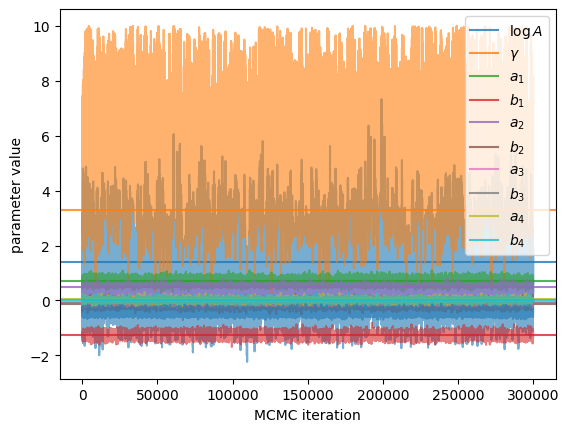

In [9]:
# parameter trace plot
ndim = samples_1[0,0].shape[0]
for i in range(ndim):
    plt.plot(samples_1[0,:,i], color=f'C{i}', alpha=0.6)
    if i != ndim - 1:
        plt.axhline(x_ML_1[i], color=f'C{i}', label=model_1.labels[i], alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend(loc='upper right')
plt.show()

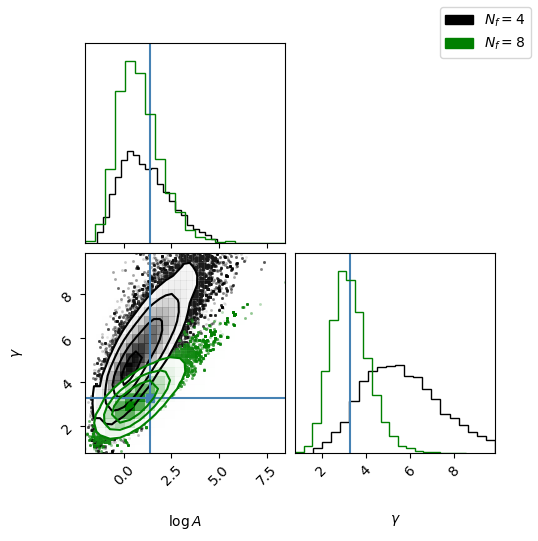

In [21]:
# corner plot
ndxs = np.arange(2)
burnin = num_samples // 5
nsamp = num_samples - burnin

fig = corner(samples_1[0, burnin:][:, ndxs],
             truths=x_ML_1[ndxs],
             labels=model_1.labels[ndxs],
             weights=np.ones(nsamp)/nsamp,
             range=[0.99]*ndxs.shape[0],
             smooth=1.0)

corner(samples_2[0, burnin:][:, ndxs], color='green',
       weights=np.ones(nsamp)/nsamp, fig=fig,
       smooth=1.0)

black_patch = mpatches.Patch(color='black', label=rf'$N_f={model_1_Nf}$')
green_patch = mpatches.Patch(color='green', label=rf'$N_f={model_2_Nf}$')
fig.legend(handles=[black_patch, green_patch], loc='upper right')
plt.show()

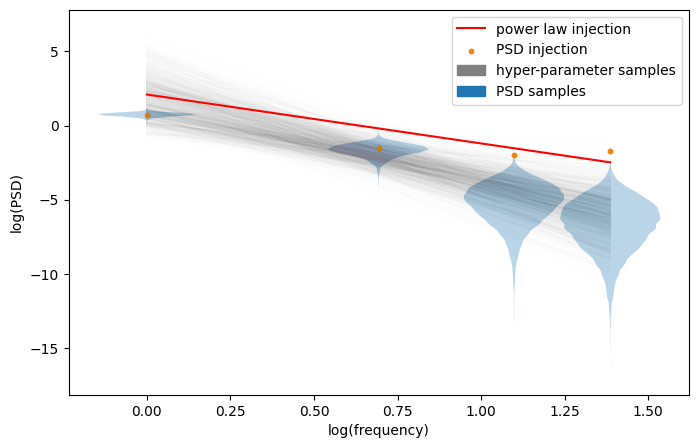

In [11]:
# violin plot
logPSDs = np.log(samples_1[0, burnin:, 2::2][:,:-1]**2. + samples_1[0, burnin:, 3::2]**2.)
plt.figure(figsize=(8, 5))
plt.violinplot(logPSDs,
               positions=logf_inj[:model_1_Nf],
               showextrema=False,
               widths=0.3)

# plot power law using fair draws
num_fair_draws = 1000
fair_draw_ndxs = np.random.choice(np.arange(burnin, num_samples), num_fair_draws)
for ndx in fair_draw_ndxs:
    diag_cov = f.fast_diag_power_law_cov(samples_1[0, ndx, 0], samples_1[0, ndx, 1], f_inj[:model_1_Nf])
    plt.plot(logf_inj[:model_1_Nf], np.log(diag_cov[::2] + diag_cov[1::2]), alpha=5./num_fair_draws, color='grey')
plt.plot(logf_inj[:model_1_Nf], np.log(diag_cov_inj[::2] + diag_cov_inj[1::2])[:model_1_Nf], color='red',
         label='power law injection')

# injected PSD
plt.scatter(logf_inj[:model_1_Nf], np.log(a_inj[::2]**2. + a_inj[1::2]**2.)[:model_1_Nf], color='C1', s=10,
            label='PSD injection')

# make legend
grey_patch = mpatches.Patch(color='grey', label='hyper-parameter samples')
blue_patch = mpatches.Patch(color='C0', label='PSD samples')
handles, labels = plt.gca().get_legend_handles_labels()
handles += [grey_patch, blue_patch]  # Add custom patches to the handles
labels += ['hyper-parameter samples', 'PSD samples']  # Add corresponding labels
plt.legend(handles=handles, labels=labels, loc='upper right')

plt.xlabel('log(frequency)')
plt.ylabel('log(PSD)')
plt.show()

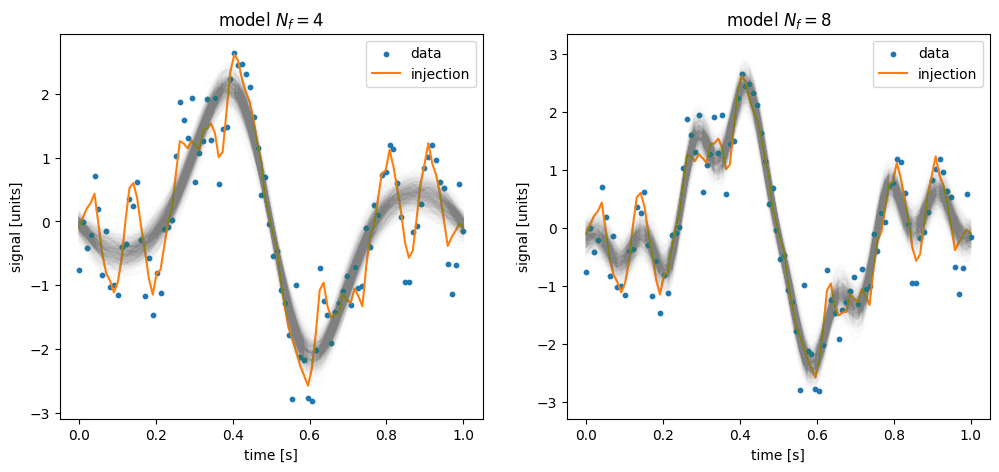

In [12]:
# Bayesogram

# fair draws from posterior
num_draws = 1000
draw_ndxs = np.random.choice(np.arange(burnin, num_samples))

# model 1 time-domain recovery
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(t, data, color='C0', s=10, label='data')
plt.plot(t, signal_inj, color='C1', label='injection')
[plt.plot(t, model_1.F @ samples_1[0, ndx, 2:-1], color='grey', alpha=5./num_fair_draws)
 for ndx in fair_draw_ndxs]
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend(loc='upper right')
plt.title(rf'model $N_f = {model_1_Nf}$')

# model 2 time-domain recovery
plt.subplot(1, 2, 2)
plt.scatter(t, data, color='C0', s=10, label='data')
plt.plot(t, signal_inj, color='C1', label='injection')
[plt.plot(t, model_2.F @ samples_2[0, ndx, 2:-1], color='grey', alpha=5./num_fair_draws)
 for ndx in fair_draw_ndxs]
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend(loc='upper right')
plt.title(rf'model $N_f = {model_2_Nf}$')
plt.show()